# Computer Vision

In [ ]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

## get dataset

In [ ]:
#using FashionMNIST
train_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

In [ ]:
image, label = test_data[0]
image, label

In [ ]:
image.shape

## visualize data

(-0.5, 27.5, 27.5, -0.5)

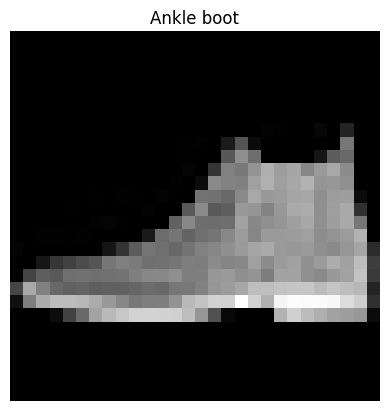

In [14]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

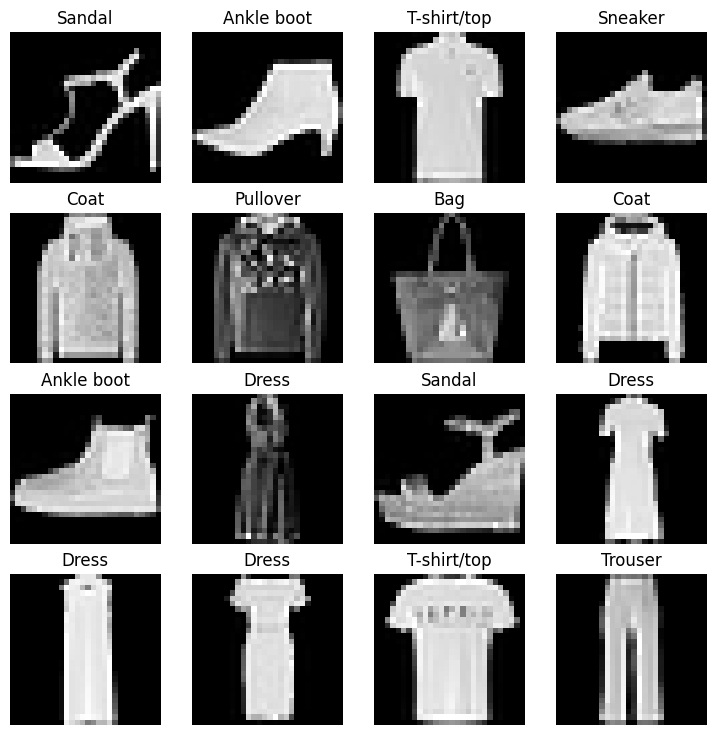

In [15]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)